# Dan's code: fitting a GP to data.

In [1]:
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [7]:
data = pd.read_csv("../data/calibration_data.csv")
m = np.isfinite(data.teff.values) & np.isfinite(data.period.values) & np.isfinite(data.age_gyr.values)
m &= data.teff.values > 3500
data = data.iloc[m]

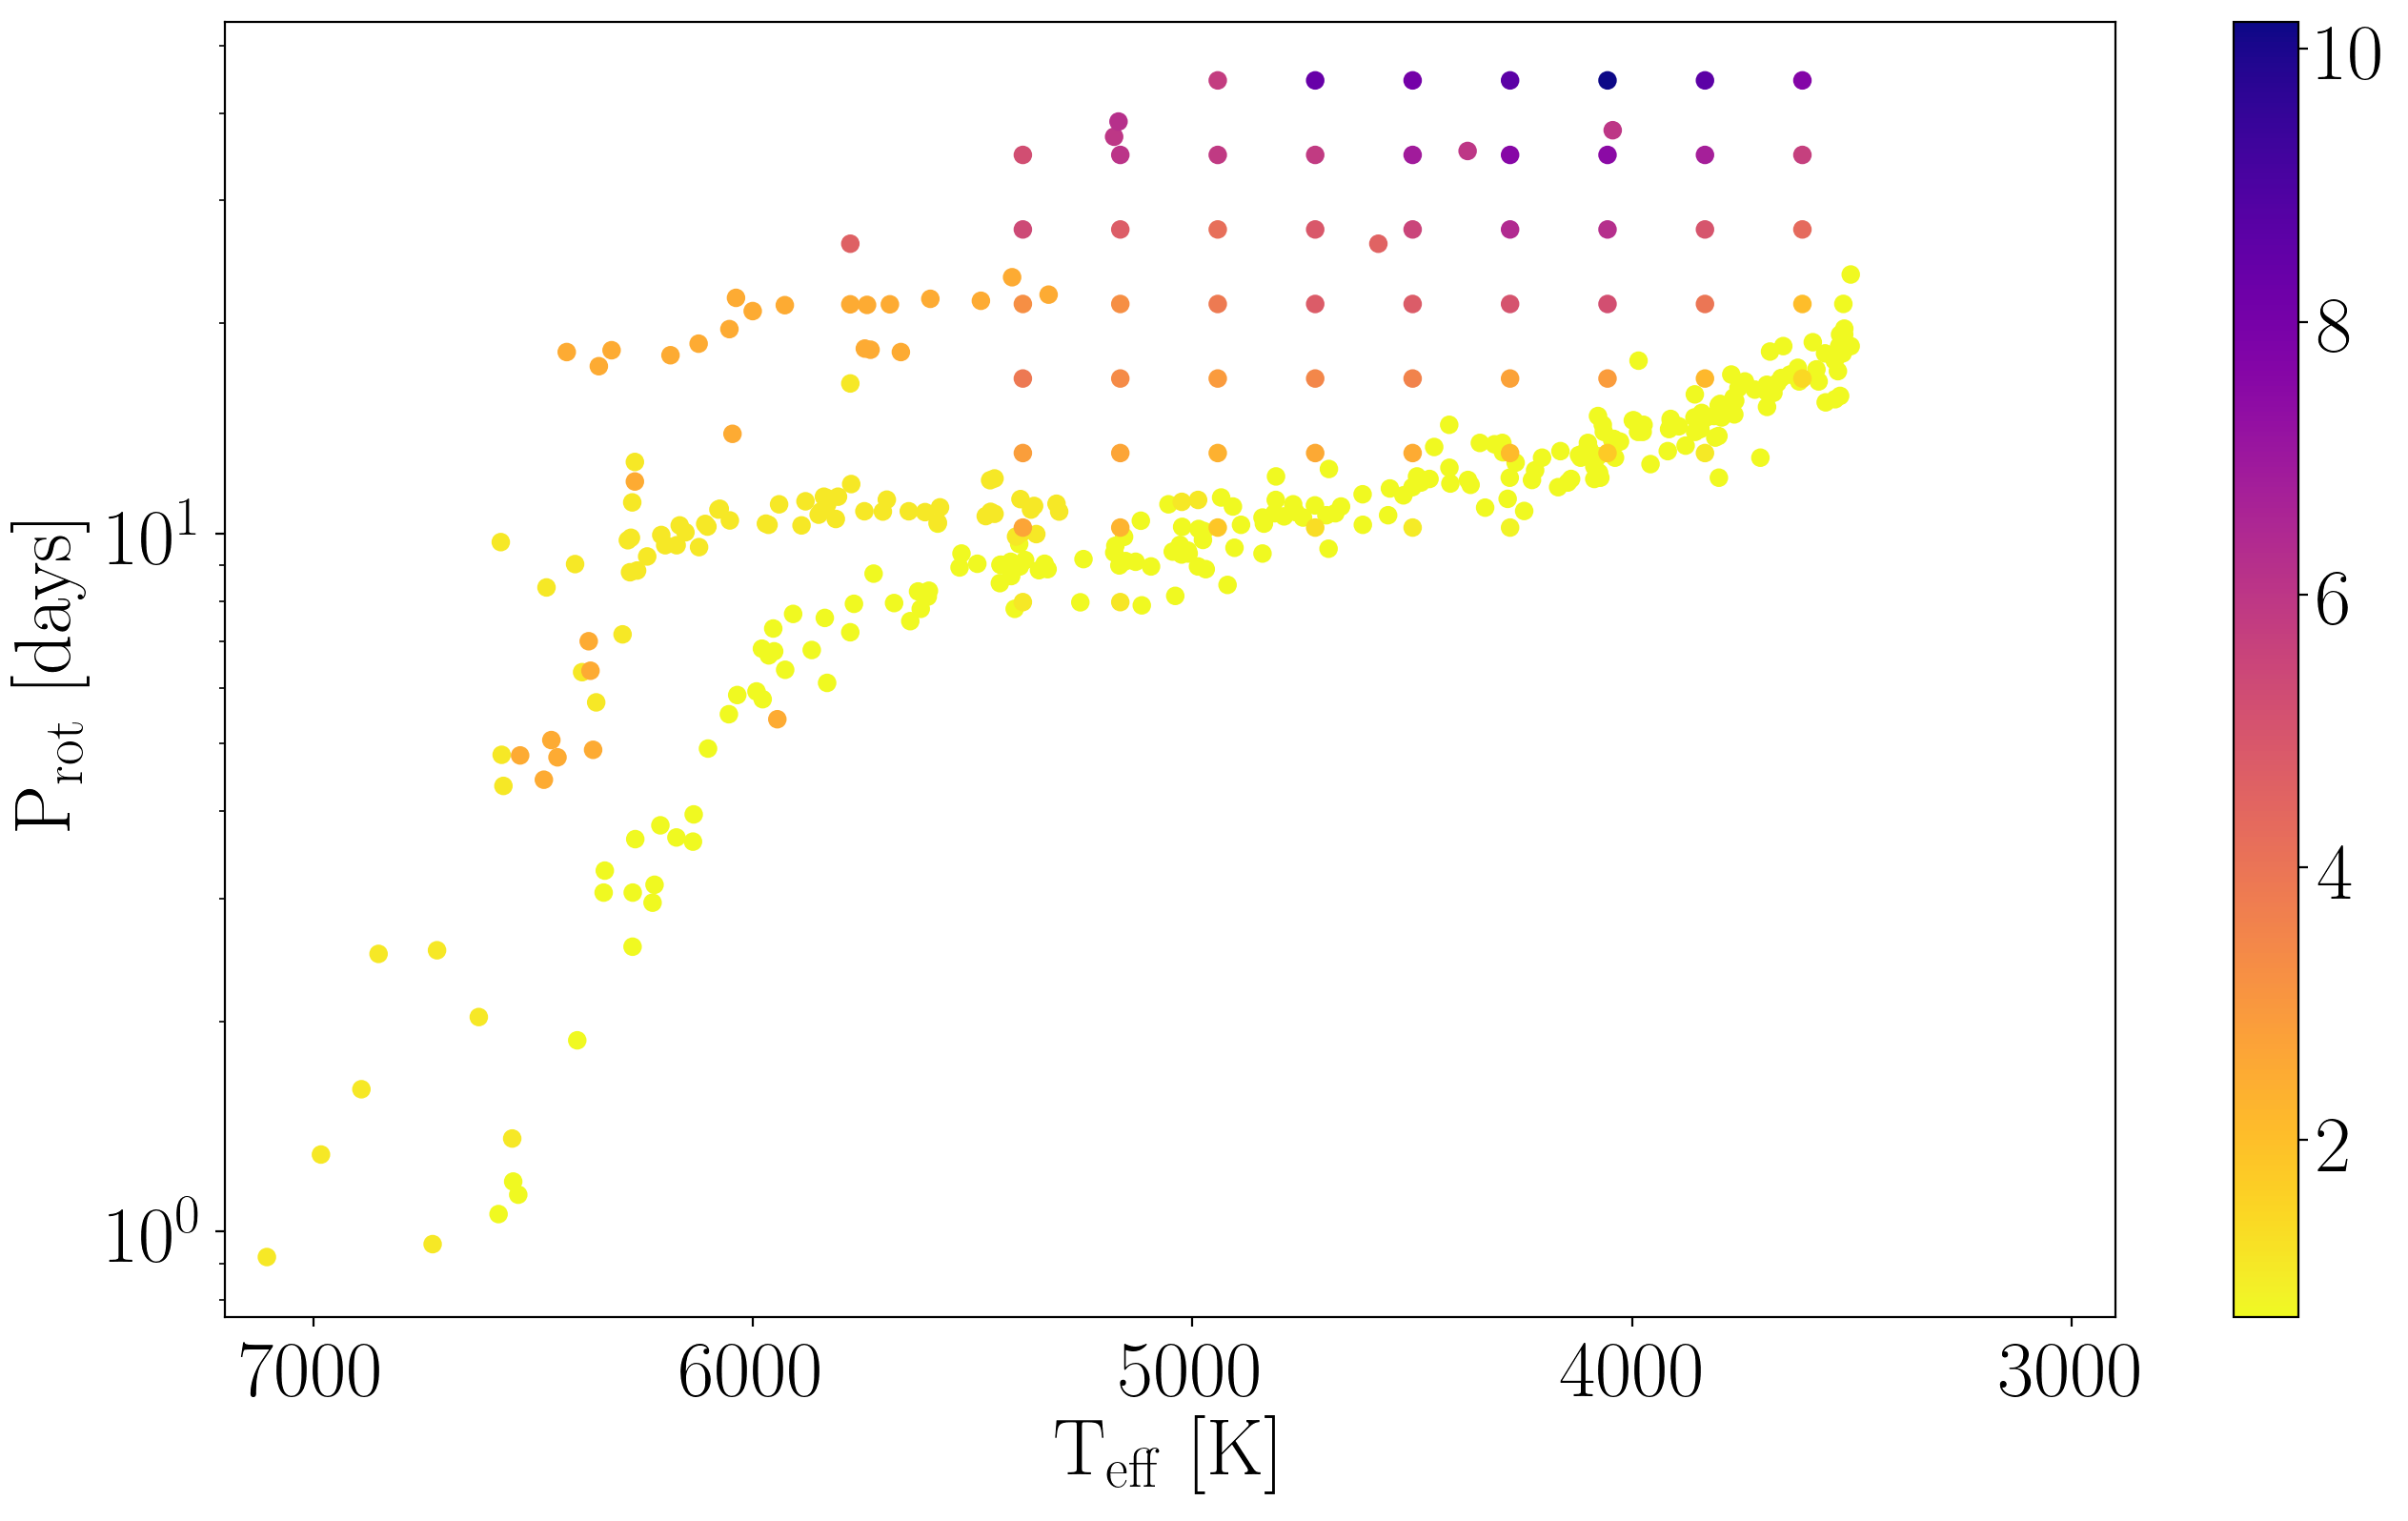

In [8]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(data.teff, data.period, c=data.age_gyr, cmap="plasma_r")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7200, 2900)
plt.yscale("log")
plt.colorbar();

Sort and format data

In [10]:
inds = np.argsort(data.teff.values)

x1 = np.array(data.teff.values[inds])
x2 = np.log(np.array(data.age_gyr.values[inds]))

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)
# x1_norm = (x1 - mu1) / sd1
# x2_norm = (x2 - mu2) / sd2

x2_min = np.min(x2)

xp1 = np.linspace(x1.min() - 500, x1.max() + 100, 1000)
xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
xg2 = np.linspace(x2.min(), x2.max(), 7)

y = np.log(np.array(data.period.values[inds]))

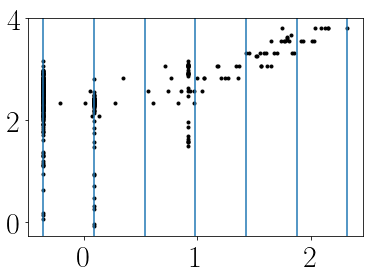

In [11]:
plt.plot(x2, y, ".k")
for i, x2_ref in enumerate(xg2):
    plt.axvline(x2_ref)

In [12]:
with pm.Model() as model:
    
    teff_break = pm.Normal("teff_break", mu=6000, sigma=500)
    log_period_break_c = pm.Normal("log_period_break_c", mu=0.0, sd=5)
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)
    smooth = tt.exp(log_smooth)
    
    def get_log_period_break(x2):
        return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)
    
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)
    
    # Mean model
    def get_mean_model(x1, x2):
        delta = x1 - teff_break
        brk = get_log_period_break(x2)
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # GP
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10.0, shape=2)
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = np.vstack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    for i, x2_ref in enumerate(xg2):
        pred_model = get_mean_model(xp1, x2_ref)
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b, log_period_break_c])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


success: True
initial logp: -591.4045400518993
final logp: -586.1519855639748
success: True
initial logp: -586.1519855639748
final logp: -586.0666428303585
success: True
initial logp: -586.0666428303585
final logp: -584.7038892935559
success: True
initial logp: -584.7038892935559
final logp: -584.6805652298864


/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr

success: True
initial logp: -584.6805652298864
final logp: 33.5048731584033


/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an

success: False
initial logp: 33.5048731584033
final logp: 36.32607946947383


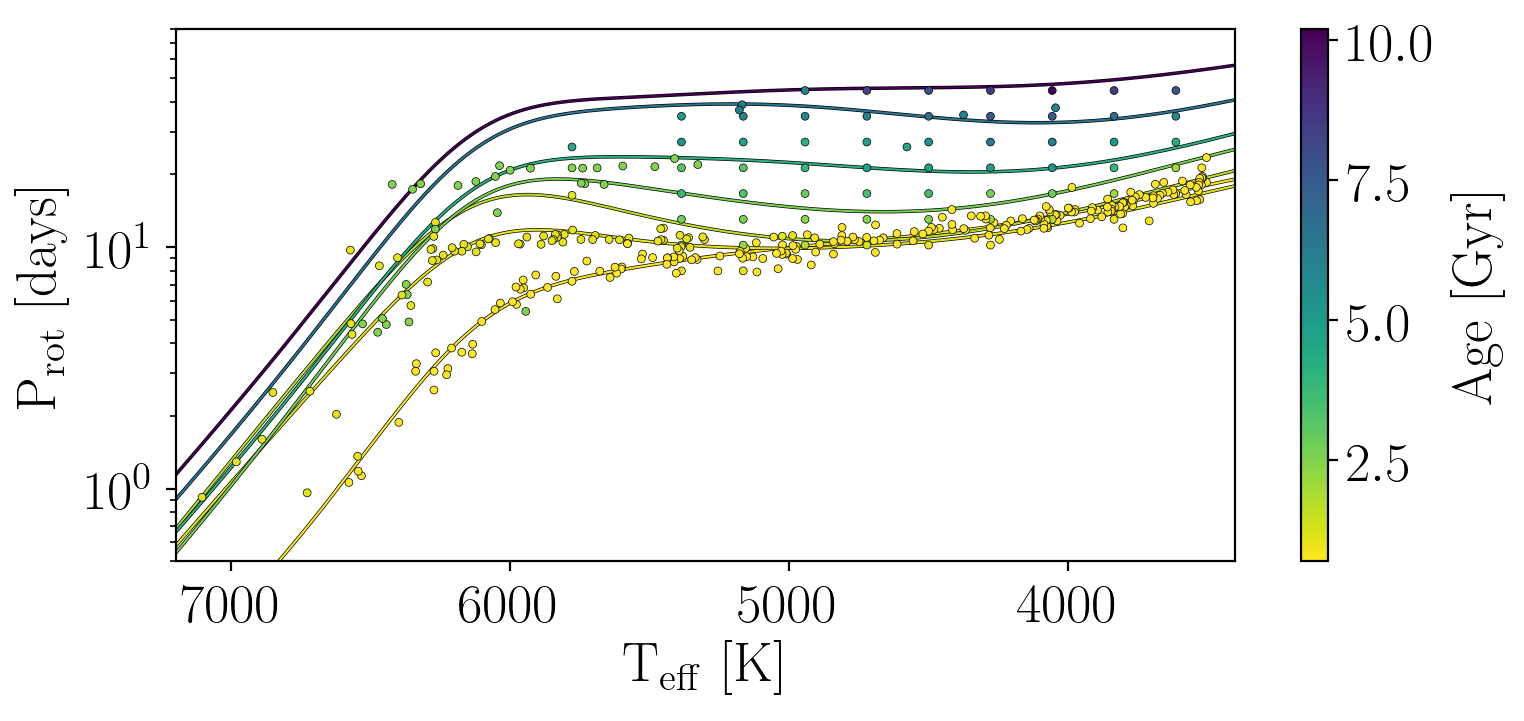

In [24]:
import matplotlib
cmap = matplotlib.cm.get_cmap("viridis_r")

plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

# inds = np.argsort(x1)
# plt.plot(x1[inds], map_soln["mean_model"][inds], "k")

for i, x2_ref in enumerate(xg2):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(x2_ref), lw=0.75)

plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
            linewidth=0.25, zorder=100)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7200, 3400)
plt.ylim(0.5, 80)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()
plt.savefig("gp_demo_viridis")
plt.savefig("gp_demo_viridis.pdf")